In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
from pathlib import Path

In [23]:
#load base model

base_model = keras.applications.InceptionV3(
                    weights='imagenet',
                    input_shape=(224, 224, 3),
                    include_top=False)

In [24]:
# Freeze base model
base_model.trainable = False

In [25]:
# add layers to model

inputs = keras.Input(shape = (224, 224, 3))

x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dense(512, activation='relu')(x)

# outputs = keras.layers.Dense(14, activation='softmax')(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [26]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21806882 (83.19 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [27]:
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              metrics = keras.metrics.CategoricalAccuracy())

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True)

test_gen = ImageDataGenerator(samplewise_center=True)

## Validation dataset
#### train/test split

I'm going to diverge from the initial notebook by making a train/test split from the training data, and hold out the test set for evaluation after model training is done.

#### Warning - not idempodent, Only Run Once!!
- **This will change the data in your training data to take ~20% of the Train data and move to a new Validate directory**

In [29]:
# Set this equal to True just to run once, then return to False
make_validation_data = False

if make_validation_data:
    training_dirs = os.listdir('dataset_binary/Train/')
    if '.DS_Store' in training_dirs:
        training_dirs.remove('.DS_Store')

    for directory in training_dirs:

        Path(f'dataset_binary/Validate/{directory}').mkdir(parents=True, exist_ok=True)

        # move 20% of files to the validation directory
        example_files = os.listdir(f'dataset_binary/Train/{directory}')

        # identify 20% of training data to move to validation set
        take_count = int(len(example_files)*.2)  
        val_files = example_files[-take_count:]
        print(f'Taking {len(val_files)} of {len(example_files)} files from Train/{directory} and moving to Validate/{directory}')

        # move the files
        for filename in val_files:
            Path(f'dataset_binary/Train/{directory}/{filename}').rename(f'dataset_binary/Validate/{directory}/{filename}')


### Make Binary Label Directory Structure

In [30]:
!pwd

/Users/mcirtain/work/ait736


In [31]:
# Reimplementing the above using the validation set for model development.

train = train_gen.flow_from_directory(
    'dataset_binary/Train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical")


val = train_gen.flow_from_directory(
    'dataset_binary/Validate',  # This was dataset_binary/Test before
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical")



Found 18901 images belonging to 2 classes.
Found 4718 images belonging to 2 classes.


In [32]:
val.class_indices
train.class_indices
assert [x for x in train.class_indices if x not in val.class_indices] == [], 'We have a mismatch in categories'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

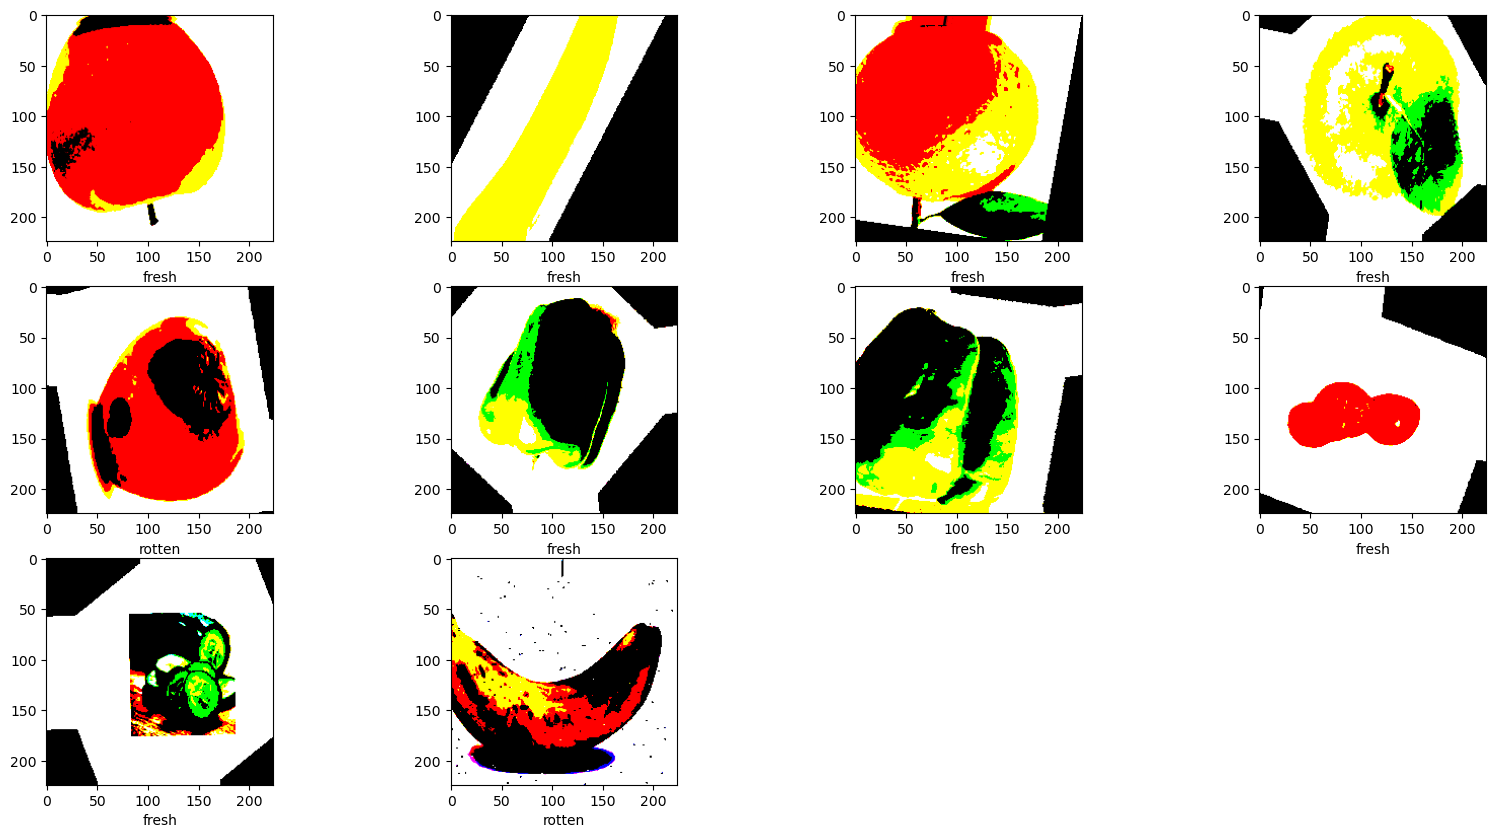

In [33]:
import matplotlib.pyplot as plt

# Encode the classes
classes = train.class_indices
classes = {indx: c for c, indx in classes.items()}


#PLotting some images 
images, labels=train.next()
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    #plt.axis('off')
    plt.xlabel(classes[np.argmax(labels[i])])

In [ ]:
# callbacks = keras.callbacks.EarlyStopping(patience = 2, monitor='val_loss')


# model.fit(train,
#           validation_data = val,
#           steps_per_epoch = train.samples/train.batch_size,
#           validation_steps= val.samples/val.batch_size,
#           epochs=8,
#           callbacks= [callbacks])

In [34]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
# model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

In [35]:
callbacks = keras.callbacks.EarlyStopping(patience = 3, monitor='val_loss')

model.fit(train,
          validation_data= val,
          steps_per_epoch= train.samples/train.batch_size,
          validation_steps= val.samples/val.batch_size,
          epochs=5,
          callbacks=[callbacks]
         )

Epoch 1/5
590/590 [==============================] - 955s 2s/step - loss: 0.2039 - categorical_accuracy: 0.9181 - val_loss: 0.0702 - val_categorical_accuracy: 0.9765
Epoch 2/5
590/590 [==============================] - 802s 1s/step - loss: 0.0704 - categorical_accuracy: 0.9745 - val_loss: 0.0392 - val_categorical_accuracy: 0.9877
Epoch 3/5
590/590 [==============================] - 819s 1s/step - loss: 0.0456 - categorical_accuracy: 0.9841 - val_loss: 0.0334 - val_categorical_accuracy: 0.9877
Epoch 4/5
590/590 [==============================] - 808s 1s/step - loss: 0.0321 - categorical_accuracy: 0.9889 - val_loss: 0.0221 - val_categorical_accuracy: 0.9919
Epoch 5/5
590/590 [==============================] - 811s 1s/step - loss: 0.0270 - categorical_accuracy: 0.9911 - val_loss: 0.0199 - val_categorical_accuracy: 0.9922


### Validation

In [54]:
# Fix test directory structure:

# !ls dataset_binary/Test
# rename freshpatato->freshpotato; freshtamto->freshtomato; rottenpatato->rottenpotato; rottentamto->rottentomato
# Following cell creates any missing classes in Test by creating empty directories for them 
# (so Test aligns with 18 possible classes)


freshapples       freshokra         rottenbanana      rottenoranges
freshbanana       freshoranges      rottenbittergroud rottenpotato
freshbittergroud  freshpotato       rottencapsicum    rottentomato
freshcapsicum     freshtomato       rottencucumber
freshcucumber     rottenapples      rottenokra


In [57]:
# # make missing directories in Test
# make_test_dirs = True
# if make_test_dirs:
#     training_dirs = os.listdir('dataset_binary/Train/')
#     if '.DS_Store' in training_dirs:
#         training_dirs.remove('.DS_Store')

#     for directory in training_dirs:

#         Path(f'dataset_binary/Test/{directory}').mkdir(parents=True, exist_ok=True)


In [36]:
# only define the test dataset now, so we know we haven't seen it before

test = test_gen.flow_from_directory(
    'dataset_binary/Test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical")


Found 6738 images belonging to 2 classes.


In [37]:
model.evaluate(test, steps= test.samples/test.batch_size)

210/210 [==============================] - 70s 334ms/step - loss: 0.0166 - categorical_accuracy: 0.9942


[0.016615603119134903, 0.9942119121551514]

### Ideas:

- Try adding an adaptive learning rate. Maybe more epochs but faster?  https://stackoverflow.com/questions/53479007/how-to-setup-adaptive-learning-rate-in-keras

